# Method 5 - Rest Ideas After 20

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 20].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

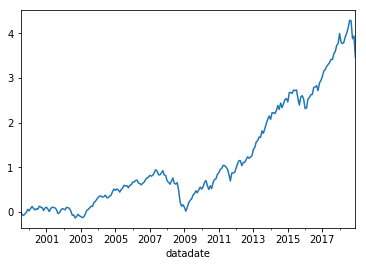

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.061025
2000-12-31    0.026580
2001-12-31   -0.012043
2002-12-31   -0.150097
2003-12-31    0.401926
2004-12-31    0.181727
2005-12-31    0.061223
2006-12-31    0.108860
2007-12-31    0.018072
2008-12-31   -0.359831
2009-12-31    0.340837
2010-12-31    0.183961
2011-12-31    0.023785
2012-12-31    0.193804
2013-12-31    0.396996
2014-12-31    0.124025
2015-12-31   -0.003303
2016-12-31    0.117623
2017-12-31    0.210330
2018-12-31   -0.065028
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1474.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.28e-162
Time:                        04:40:00   Log-Likelihood:                 808.05
No. Observations:                 234   AIC:                            -1606.
Df Residuals:                     229   BIC:                            -1589.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.169      0.000       0.001       0.003
mktrf          0.8912      0.014     61.738      0.000       0.863       0.920
me             0.2030      0.017     12.091      0.000       0.170       0.236
ia             0.1452      0.026      5.688      0.000       0.095       0.195
roe            0.1000      0.022      4.579      0.000       0.057       0.143
==============================================================================
Omnibus:                       12.649   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.376
Skew:                           0.146   Prob(JB):                     6.89e-07
Kurtosis:                       4.681   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     759.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.19e-131
Time:                        04:40:00   Log-Likelihood:                 808.05
No. Observations:                 234   AIC:                            -1606.
Df Residuals:                     229   BIC:                            -1589.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.938      0.000       0.001       0.003
mktrf          0.8912      0.019     47.204      0.000       0.854       0.928
me             0.2030      0.031      6.484      0.000       0.142       0.264
ia             0.1452      0.055      2.628      0.009       0.037       0.253
roe            0.1000      0.022      4.521      0.000       0.057       0.143
==============================================================================
Omnibus:                       12.649   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.376
Skew:                           0.146   Prob(JB):                     6.89e-07
Kurtosis:                       4.681   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     906.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.59e-139
Time:                        04:40:00   Log-Likelihood:                 808.05
No. Observations:                 234   AIC:                            -1606.
Df Residuals:                     229   BIC:                            -1589.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.048      0.000       0.001       0.003
mktrf          0.8912      0.018     50.753      0.000       0.857       0.926
me             0.2030      0.029      6.889      0.000       0.145       0.261
ia             0.1452      0.062      2.347      0.019       0.024       0.266
roe            0.1000      0.023      4.435      0.000       0.056       0.144
==============================================================================
Omnibus:                       12.649   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.376
Skew:                           0.146   Prob(JB):                     6.89e-07
Kurtosis:                       4.681   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1133.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.89e-159
Time:                        04:40:00   Log-Likelihood:                 804.02
No. Observations:                 234   AIC:                            -1596.
Df Residuals:                     228   BIC:                            -1575.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.317      0.001       0.001       0.003
mktrf          0.9014      0.015     61.122      0.000       0.872       0.930
smb            0.2326      0.019     11.954      0.000       0.194       0.271
hml           -0.0108      0.023     -0.473      0.637      -0.056       0.034
rmw            0.1396      0.026      5.382      0.000       0.089       0.191
cma            0.1326      0.033      4.021      0.000       0.068       0.198
==============================================================================
Omnibus:                       17.786   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.221
Skew:                          -0.111   Prob(JB):                     6.19e-13
Kurtosis:                       5.391   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     520.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.65e-122
Time:                        04:40:00   Log-Likelihood:                 804.02
No. Observations:                 234   AIC:                            -1596.
Df Residuals:                     228   BIC:                            -1575.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.209      0.001       0.001       0.003
mktrf          0.9014      0.023     38.853      0.000       0.856       0.947
smb            0.2326      0.027      8.648      0.000       0.180       0.285
hml           -0.0108      0.047     -0.231      0.817      -0.103       0.081
rmw            0.1396      0.023      5.996      0.000       0.094       0.185
cma            0.1326      0.059      2.232      0.026       0.016       0.249
==============================================================================
Omnibus:                       17.786   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.221
Skew:                          -0.111   Prob(JB):                     6.19e-13
Kurtosis:                       5.391   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     672.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.74e-134
Time:                        04:40:00   Log-Likelihood:                 804.02
No. Observations:                 234   AIC:                            -1596.
Df Residuals:                     228   BIC:                            -1575.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.209      0.001       0.001       0.003
mktrf          0.9014      0.022     40.104      0.000       0.857       0.945
smb            0.2326      0.026      8.916      0.000       0.181       0.284
hml           -0.0108      0.053     -0.205      0.838      -0.115       0.093
rmw            0.1396      0.020      7.056      0.000       0.101       0.178
cma            0.1326      0.056      2.358      0.018       0.022       0.243
==============================================================================
Omnibus:                       17.786   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.221
Skew:                          -0.111   Prob(JB):                     6.19e-13
Kurtosis:                       5.391   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1158.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.33e-150
Time:                        04:40:00   Log-Likelihood:                 781.00
No. Observations:                 234   AIC:                            -1552.
Df Residuals:                     229   BIC:                            -1535.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.644      0.000       0.002       0.004
mktrf          0.8696      0.015     58.287      0.000       0.840       0.899
smb            0.1605      0.019      8.617      0.000       0.124       0.197
hml            0.1354      0.019      7.318      0.000       0.099       0.172
umd            0.0376      0.012      3.094      0.002       0.014       0.061
==============================================================================
Omnibus:                       23.689   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.093
Skew:                           0.148   Prob(JB):                     3.04e-22
Kurtosis:                       6.174   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     595.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.03e-119
Time:                        04:40:00   Log-Likelihood:                 781.00
No. Observations:                 234   AIC:                            -1552.
Df Residuals:                     229   BIC:                            -1535.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.156      0.000       0.001       0.004
mktrf          0.8696      0.021     40.633      0.000       0.828       0.912
smb            0.1605      0.032      5.062      0.000       0.098       0.223
hml            0.1354      0.061      2.213      0.027       0.015       0.255
umd            0.0376      0.020      1.843      0.065      -0.002       0.078
==============================================================================
Omnibus:                       23.689   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.093
Skew:                           0.148   Prob(JB):                     3.04e-22
Kurtosis:                       6.174   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     681.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.88e-126
Time:                        04:40:00   Log-Likelihood:                 781.00
No. Observations:                 234   AIC:                            -1552.
Df Residuals:                     229   BIC:                            -1535.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.390      0.000       0.001       0.004
mktrf          0.8696      0.020     42.445      0.000       0.829       0.910
smb            0.1605      0.033      4.848      0.000       0.096       0.225
hml            0.1354      0.072      1.885      0.059      -0.005       0.276
umd            0.0376      0.016      2.295      0.022       0.005       0.070
==============================================================================
Omnibus:                       23.689   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.093
Skew:                           0.148   Prob(JB):                     3.04e-22
Kurtosis:                       6.174   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     653.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.52e-78
Time:                        04:40:00   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -785.0
Df Residuals:                     115   BIC:                            -771.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.353      0.020       0.000       0.004
mktrf          0.9033      0.023     38.931      0.000       0.857       0.949
me             0.2040      0.023      8.902      0.000       0.159       0.249
ia             0.2032      0.036      5.664      0.000       0.132       0.274
roe            0.1101      0.032      3.466      0.001       0.047       0.173
==============================================================================
Omnibus:                        6.386   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.041   Jarque-Bera (JB):               10.017
Skew:                           0.135   Prob(JB):                      0.00668
Kurtosis:                       4.389   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     373.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.71e-65
Time:                        04:40:00   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -785.0
Df Residuals:                     115   BIC:                            -771.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.165      0.030       0.000       0.004
mktrf          0.9033      0.027     33.020      0.000       0.850       0.957
me             0.2040      0.035      5.882      0.000       0.136       0.272
ia             0.2032      0.057      3.545      0.000       0.091       0.316
roe            0.1101      0.022      4.992      0.000       0.067       0.153
==============================================================================
Omnibus:                        6.386   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.041   Jarque-Bera (JB):               10.017
Skew:                           0.135   Prob(JB):                      0.00668
Kurtosis:                       4.389   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     642.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.23e-77
Time:                        04:40:00   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -785.0
Df Residuals:                     115   BIC:                            -771.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.298      0.022       0.000       0.004
mktrf          0.9033      0.022     41.349      0.000       0.860       0.946
me             0.2040      0.033      6.135      0.000       0.139       0.269
ia             0.2032      0.058      3.475      0.001       0.089       0.318
roe            0.1101      0.019      5.688      0.000       0.072       0.148
==============================================================================
Omnibus:                        6.386   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.041   Jarque-Bera (JB):               10.017
Skew:                           0.135   Prob(JB):                      0.00668
Kurtosis:                       4.389   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     470.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.45e-74
Time:                        04:40:00   Log-Likelihood:                 391.94
No. Observations:                 120   AIC:                            -771.9
Df Residuals:                     114   BIC:                            -755.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.179      0.031       0.000       0.004
mktrf          0.9253      0.026     35.945      0.000       0.874       0.976
smb            0.2443      0.029      8.379      0.000       0.187       0.302
hml            0.0075      0.036      0.211      0.833      -0.063       0.078
rmw            0.1508      0.042      3.579      0.001       0.067       0.234
cma            0.1744      0.046      3.779      0.000       0.083       0.266
==============================================================================
Omnibus:                       10.230   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.951
Skew:                          -0.081   Prob(JB):                     3.82e-06
Kurtosis:                       5.228   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     350.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.83e-67
Time:                        04:40:00   Log-Likelihood:                 391.94
No. Observations:                 120   AIC:                            -771.9
Df Residuals:                     114   BIC:                            -755.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.112      0.035       0.000       0.004
mktrf          0.9253      0.043     21.617      0.000       0.841       1.009
smb            0.2443      0.039      6.331      0.000       0.169       0.320
hml            0.0075      0.082      0.092      0.926      -0.152       0.167
rmw            0.1508      0.054      2.802      0.005       0.045       0.256
cma            0.1744      0.078      2.225      0.026       0.021       0.328
==============================================================================
Omnibus:                       10.230   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.951
Skew:                          -0.081   Prob(JB):                     3.82e-06
Kurtosis:                       5.228   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     793.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.82e-87
Time:                        04:40:00   Log-Likelihood:                 391.94
No. Observations:                 120   AIC:                            -771.9
Df Residuals:                     114   BIC:                            -755.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.417      0.016       0.000       0.004
mktrf          0.9253      0.040     22.923      0.000       0.846       1.004
smb            0.2443      0.036      6.767      0.000       0.174       0.315
hml            0.0075      0.093      0.081      0.935      -0.175       0.190
rmw            0.1508      0.054      2.789      0.005       0.045       0.257
cma            0.1744      0.077      2.256      0.024       0.023       0.326
==============================================================================
Omnibus:                       10.230   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.951
Skew:                          -0.081   Prob(JB):                     3.82e-06
Kurtosis:                       5.228   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     483.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.72e-71
Time:                        04:40:00   Log-Likelihood:                 380.27
No. Observations:                 120   AIC:                            -750.5
Df Residuals:                     115   BIC:                            -736.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.331      0.001       0.001       0.005
mktrf          0.8708      0.024     36.896      0.000       0.824       0.918
smb            0.1680      0.027      6.253      0.000       0.115       0.221
hml            0.1895      0.027      7.039      0.000       0.136       0.243
umd            0.0371      0.017      2.236      0.027       0.004       0.070
==============================================================================
Omnibus:                       16.865   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.876
Skew:                           0.197   Prob(JB):                     4.96e-15
Kurtosis:                       6.608   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     359.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.65e-64
Time:                        04:40:00   Log-Likelihood:                 380.27
No. Observations:                 120   AIC:                            -750.5
Df Residuals:                     115   BIC:                            -736.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.110      0.002       0.001       0.005
mktrf          0.8708      0.034     25.933      0.000       0.805       0.937
smb            0.1680      0.037      4.580      0.000       0.096       0.240
hml            0.1895      0.073      2.591      0.010       0.046       0.333
umd            0.0371      0.021      1.745      0.081      -0.005       0.079
==============================================================================
Omnibus:                       16.865   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.876
Skew:                           0.197   Prob(JB):                     4.96e-15
Kurtosis:                       6.608   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     493.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.15e-71
Time:                        04:40:01   Log-Likelihood:                 380.27
No. Observations:                 120   AIC:                            -750.5
Df Residuals:                     115   BIC:                            -736.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.517      0.000       0.001       0.005
mktrf          0.8708      0.028     31.160      0.000       0.816       0.926
smb            0.1680      0.040      4.231      0.000       0.090       0.246
hml            0.1895      0.081      2.330      0.020       0.030       0.349
umd            0.0371      0.017      2.207      0.027       0.004       0.070
==============================================================================
Omnibus:                       16.865   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.876
Skew:                           0.197   Prob(JB):                     4.96e-15
Kurtosis:                       6.608   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1173.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.38e-88
Time:                        04:40:01   Log-Likelihood:                 435.47
No. Observations:                 114   AIC:                            -860.9
Df Residuals:                     109   BIC:                            -847.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      4.470      0.000       0.001       0.003
mktrf          0.8875      0.016     55.626      0.000       0.856       0.919
me             0.1984      0.025      8.055      0.000       0.150       0.247
ia            -0.0292      0.034     -0.854      0.395      -0.097       0.039
roe            0.0219      0.030      0.729      0.468      -0.038       0.081
==============================================================================
Omnibus:                        0.554   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.525
Skew:                           0.161   Prob(JB):                        0.769
Kurtosis:                       2.916   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     947.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.16e-83
Time:                        04:40:01   Log-Likelihood:                 435.47
No. Observations:                 114   AIC:                            -860.9
Df Residuals:                     109   BIC:                            -847.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      4.214      0.000       0.001       0.004
mktrf          0.8875      0.018     50.006      0.000       0.853       0.922
me             0.1984      0.032      6.295      0.000       0.137       0.260
ia            -0.0292      0.040     -0.734      0.463      -0.107       0.049
roe            0.0219      0.029      0.753      0.452      -0.035       0.079
==============================================================================
Omnibus:                        0.554   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.525
Skew:                           0.161   Prob(JB):                        0.769
Kurtosis:                       2.916   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     930.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.08e-83
Time:                        04:40:01   Log-Likelihood:                 435.47
No. Observations:                 114   AIC:                            -860.9
Df Residuals:                     109   BIC:                            -847.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.620      0.000       0.001       0.004
mktrf          0.8875      0.018     48.924      0.000       0.852       0.923
me             0.1984      0.035      5.708      0.000       0.130       0.267
ia            -0.0292      0.045     -0.650      0.515      -0.117       0.059
roe            0.0219      0.024      0.907      0.364      -0.025       0.069
==============================================================================
Omnibus:                        0.554   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.525
Skew:                           0.161   Prob(JB):                        0.769
Kurtosis:                       2.916   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1354.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.14e-95
Time:                        04:40:01   Log-Likelihood:                 456.49
No. Observations:                 114   AIC:                            -901.0
Df Residuals:                     108   BIC:                            -884.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.366      0.001       0.001       0.002
mktrf          0.8916      0.013     70.137      0.000       0.866       0.917
smb            0.1995      0.021      9.666      0.000       0.159       0.240
hml           -0.0999      0.026     -3.794      0.000      -0.152      -0.048
rmw           -0.0095      0.032     -0.296      0.768      -0.073       0.054
cma            0.0539      0.041      1.318      0.190      -0.027       0.135
==============================================================================
Omnibus:                        2.906   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.650
Skew:                          -0.152   Prob(JB):                        0.266
Kurtosis:                       3.682   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2257.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.70e-107
Time:                        04:40:01   Log-Likelihood:                 456.49
No. Observations:                 114   AIC:                            -901.0
Df Residuals:                     108   BIC:                            -884.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.164      0.002       0.001       0.002
mktrf          0.8916      0.014     63.645      0.000       0.864       0.919
smb            0.1995      0.025      7.850      0.000       0.150       0.249
hml           -0.0999      0.031     -3.231      0.001      -0.160      -0.039
rmw           -0.0095      0.023     -0.416      0.678      -0.054       0.035
cma            0.0539      0.056      0.969      0.333      -0.055       0.163
==============================================================================
Omnibus:                        2.906   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.650
Skew:                          -0.152   Prob(JB):                        0.266
Kurtosis:                       3.682   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     4253.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.01e-122
Time:                        04:40:01   Log-Likelihood:                 456.49
No. Observations:                 114   AIC:                            -901.0
Df Residuals:                     108   BIC:                            -884.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.636      0.008       0.000       0.003
mktrf          0.8916      0.014     64.523      0.000       0.864       0.919
smb            0.1995      0.025      7.889      0.000       0.150       0.249
hml           -0.0999      0.031     -3.204      0.001      -0.161      -0.039
rmw           -0.0095      0.024     -0.398      0.691      -0.057       0.037
cma            0.0539      0.059      0.915      0.360      -0.062       0.169
==============================================================================
Omnibus:                        2.906   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.650
Skew:                          -0.152   Prob(JB):                        0.266
Kurtosis:                       3.682   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1655.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.42e-96
Time:                        04:40:01   Log-Likelihood:                 454.71
No. Observations:                 114   AIC:                            -899.4
Df Residuals:                     109   BIC:                            -885.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.419      0.001       0.001       0.002
mktrf          0.8922      0.013     69.856      0.000       0.867       0.917
smb            0.2011      0.020     10.101      0.000       0.162       0.241
hml           -0.0552      0.021     -2.691      0.008      -0.096      -0.015
umd           -0.0008      0.015     -0.051      0.959      -0.031       0.030
==============================================================================
Omnibus:                        3.395   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.486
Skew:                          -0.131   Prob(JB):                        0.175
Kurtosis:                       3.816   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2382.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.55e-105
Time:                        04:40:01   Log-Likelihood:                 454.71
No. Observations:                 114   AIC:                            -899.4
Df Residuals:                     109   BIC:                            -885.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.417      0.001       0.001       0.002
mktrf          0.8922      0.013     66.823      0.000       0.866       0.918
smb            0.2011      0.024      8.438      0.000       0.154       0.248
hml           -0.0552      0.019     -2.853      0.004      -0.093      -0.017
umd           -0.0008      0.016     -0.049      0.961      -0.032       0.031
==============================================================================
Omnibus:                        3.395   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.486
Skew:                          -0.131   Prob(JB):                        0.175
Kurtosis:                       3.816   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     4568.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.36e-120
Time:                        04:40:01   Log-Likelihood:                 454.71
No. Observations:                 114   AIC:                            -899.4
Df Residuals:                     109   BIC:                            -885.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.865      0.004       0.000       0.003
mktrf          0.8922      0.013     69.469      0.000       0.867       0.917
smb            0.2011      0.024      8.509      0.000       0.155       0.247
hml           -0.0552      0.020     -2.769      0.006      -0.094      -0.016
umd           -0.0008      0.018     -0.044      0.965      -0.036       0.034
==============================================================================
Omnibus:                        3.395   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.486
Skew:                          -0.131   Prob(JB):                        0.175
Kurtosis:                       3.816   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""